# Megabus Bus Fares

In [75]:
origin = 'DC'
destination = 'NYC'

In [76]:
#papermill_description=define_functions
import pandas
import requests
import datetime

def get_id(name):
    d_name_to_id = { 'NYC': 123,       
        'Philadelphia': 127,      
        'Baltimore':   143,
        'VA Beach': 475,
        'DC': 142 }

    return d_name_to_id[name]

def compute_date(delta=0):
    """return date 'delta' days from now in format %Y-%m-%d, e.g., 2022-12-02"""
    now = datetime.datetime.now()
    dt = now + datetime.timedelta(days=delta)
    return dt.strftime('%Y-%m-%d')

def get_data(departure_date, origin, destination):

    origin_id = get_id(origin)
    destination_id = get_id(destination)

    """returns a dataframe from megabus with the rides on the indicated departure_date"""
    # need to override default requests header otherwise Megabus will categorize the request as a bot
    headers = { 'User-Agent': 'Mozilla/5.1'}
    url_path = 'https://us.megabus.com/journey-planner/api/journeys'
    r = requests.get( f'{url_path}?originId={origin_id}&destinationId={destination_id}&departureDate={departure_date}&totalPassengers=1&concessionCount=0&nusCount=0&otherDisabilityCount=0&wheelchairSeated=0&pcaCount=0&days=1')

    # fix dataframe
    df = pandas.DataFrame(r.json()['journeys'])
    df.set_index('journeyId', inplace=True)
    df.drop(['legs', 'origin', 'destination', 'reservableType', 'lowStockCount', 'routeName',  'duration', 'serviceInformation', 'promotionCodeStatus'], axis=1, inplace=True)
    df['origin'] = origin
    df['destination'] = destination

    df.departureDateTime = pandas.to_datetime(df.departureDateTime)
    df.arrivalDateTime = pandas.to_datetime(df.arrivalDateTime)

    df.price = df.price.astype(str).astype(float)

    # re-order columns
    df = df[['origin', 'destination', 'departureDateTime', 'arrivalDateTime', 'price']]

    return df

In [77]:
# fetch round trip data

df = pandas.DataFrame()


for i in range(0, 65):
    try:
        df = pandas.concat([df, get_data(compute_date(i), origin, destination)], axis=0)
        df = pandas.concat([df, get_data(compute_date(i), destination, origin)], axis=0)
    except:
        break

max_day = i
# df

## Fare Analysis

In [78]:
print(f'Analyzing fares between {origin} and {destination} for the next {max_day} days')

Analyzing fares between DC and NYC for the next 45 days


### Fares < $10

In [79]:
df[df.price < 10]

,origin,destination,departureDateTime,arrivalDateTime,price
journeyId,,,,,
19903121,NYC,DC,2022-12-31 18:00:00,2022-12-31 22:30:00,1.0
19903505,NYC,DC,2022-12-31 21:30:00,2023-01-01 01:50:00,1.0
19899024,NYC,DC,2023-01-09 06:00:00,2023-01-09 10:20:00,1.0


### Fares Distribution

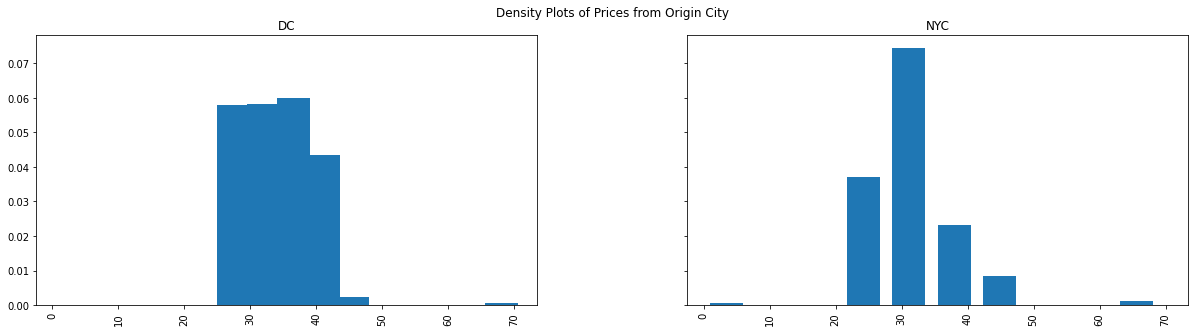

In [80]:
import matplotlib.pyplot as plt

df.hist(column='price', by='origin', width=5, grid=True, sharex= True, sharey=True, density=True, figsize=(20, 5));
plt.suptitle('Density Plots of Prices from Origin City');